<h1>SI 370 Final Project — Predicting Genre of GoodReads Books</h1>
Sonali Pai & Haley Johnson

In [ ]:
# pip install -U sentence-transformers

In [256]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import seaborn as sns
import string
import matplotlib.pyplot as plt
from langdetect import DetectorFactory, detect_langs, detect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
import networkx as nx

import sklearn 
from sklearn.metrics.pairwise import linear_kernel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import CategoricalNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras import layers, Sequential

In [2]:
sns.set_theme(context = 'notebook', style = 'darkgrid')

In [3]:
df = pd.read_csv(ZipFile("data/GoodReads_100k_books.csv.zip").open('GoodReads_100k_books.csv'))

In [4]:
df.head()

author bookformat  \
0              Laurence M. Hauptman  Hardcover   
1  Charlotte Fiell,Emmanuelle Dirix  Paperback   
2                     Andy Anderson  Paperback   
3              Carlotta R. Anderson  Hardcover   
4                     Jean Leveille        NaN   

                                                desc  \
0  Reveals that several hundred thousand Indians ...   
1  Fashion Sourcebook - 1920s is the first book i...   
2  The seminal history and analysis of the Hungar...   
3  "All-American Anarchist" chronicles the life a...   
4  Aujourdâ€™hui, lâ€™oiseau nous invite Ã  sa ta...   

                                               genre  \
0  History,Military History,Civil War,American Hi...   
1          Couture,Fashion,Historical,Art,Nonfiction   
2                                   Politics,History   
3                                      Labor,History   
4                                                NaN   

                                                 img        isbn    isbn13  \
0  https://i.gr-assets.com/images/S/compressed.ph...  002914180X  9.78E+12   
1  https://i.gr-assets.com/images/S/compressed.ph...  1906863482  9.78E+12   
2  https://i.gr-assets.com/images/S/compressed.ph...   948984147  9.78E+12   
3  https://i.gr-assets.com/images/S/compressed.ph...   814327079  9.78E+12   
4  https://i.gr-assets.com/images/S/compressed.ph...  2761920813       NaN   

                                                link  pages  rating  reviews  \
0  https://goodreads.com/book/show/1001053.Betwee...      0    3.52        5   
1  https://goodreads.com/book/show/10010552-fashi...    576    4.51        6   
2  https://goodreads.com/book/show/1001077.Hungar...    124    4.15        2   
3  https://goodreads.com/book/show/1001079.All_Am...    324    3.83        1   
4  https://goodreads.com/book/show/10010880-les-o...    177    4.00        1   

                                               title  totalratings  
0  Between Two Fires: American Indians in the Civ...            33  
1                           Fashion Sourcebook 1920s            41  
2                                         Hungary 56            26  
3  All-American Anarchist: Joseph A. Labadie and ...             6  
4                              Les oiseaux gourmands             1

<h2>Prepare Book Descriptions for Text Analysis</h2>

In [5]:
df = df.dropna(subset = ['desc', 'genre'])

In [7]:
# NOTE: this cell takes a long time to run!

# keep results consistent across runs
DetectorFactory.seed = 42

def get_lang(s: str):
    try:
        return detect(s)
    except:
        return 'unable to detect language'

df['desc_language'] = df.desc.apply(get_lang)
df = df[df.desc_language == 'en']

In [8]:
# normalize & remove whitespace 
df['desc'] = df.desc.str.lower().str.strip()

# remove quotes at start of description
df['desc'] = df.desc.str.replace("^'", "", regex = True)
df['desc'] = df.desc.str.replace('^"', "", regex = True)

# remove quotets at end of description 
df['desc'] = df.desc.str.replace("'$", "", regex = True)
df['desc'] = df.desc.str.replace('"$', "", regex = True)

# fix apostrophe's 
df['desc'] = df.desc.str.replace("\'", "'", regex = True) 

# remove non-ascii characters (takes a while to run)
punc = """ '",{}[].`;:  !? —"""
valid_chars = df.desc.apply(lambda s: [w for w in s if ((w in string.ascii_letters) or (w in string.digits) or (w in punc))])
df['desc'] = valid_chars.apply(lambda s: "".join(s))

# lemmatize words
lemmatizer = WordNetLemmatizer()
df['tokens'] = df.desc.apply(word_tokenize)
df['lemmas'] = df.tokens.apply(lambda s: [lemmatizer.lemmatize(w) for w in s])
df['desc'] = df.lemmas.apply(lambda s: " ".join(s))

In [9]:
df.to_csv('cleaned_df.csv', index = False)

<h2>Visualize Genre Distributions</h2>

In [313]:
df = pd.read_csv("cleaned_df.csv")

In [314]:
df['genres'] = df.genre.apply(lambda s: str(s).split(","))
df['top_genre'] = df.genres.apply(lambda s: s[0])

In [315]:
df.genres.apply(len).mean(), df.genres.apply(len).median()

(9.561177307487107, 10.0)

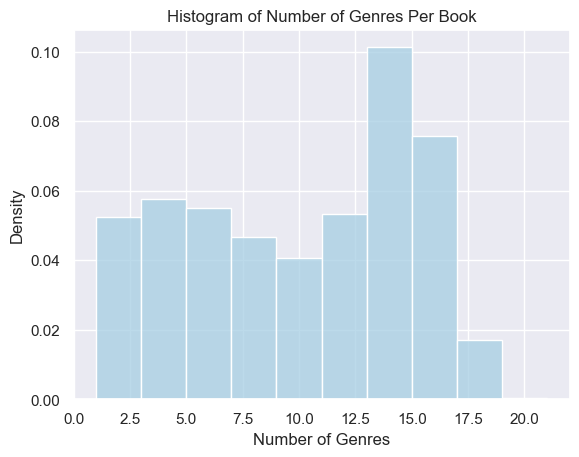

In [316]:
f = sns.histplot(df.genres.apply(len), stat = 'density', binwidth = 2)
_ = f.set(title = 'Histogram of Number of Genres Per Book', xlabel = 'Number of Genres', 
      ylabel = 'Density')

In [317]:
df.desc.apply(len).mean(), df.desc.apply(len).median()

(877.5087904270724, 788.5)

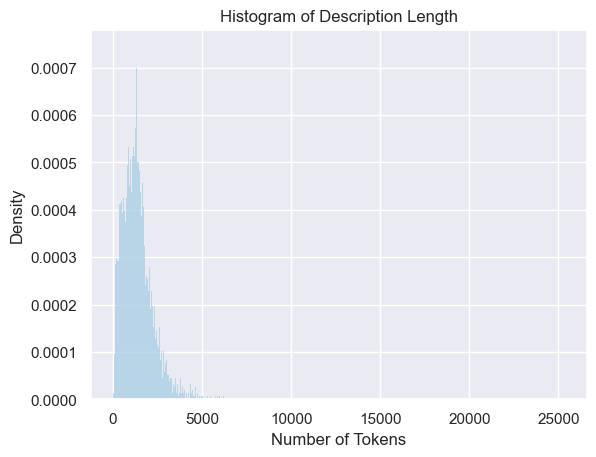

In [318]:
f = sns.histplot(df.tokens.apply(len), stat = 'density', binwidth = 2)
_ = f.set(title = 'Histogram of Description Length', xlabel = 'Number of Tokens', 
      ylabel = 'Density')

In [319]:
all_genres = df.explode("genres")
genre_counts = all_genres.genres.value_counts()

In [320]:
genre_counts.shape[0], genre_counts.mean(), genre_counts.median()

(1173, 641.6666666666666, 90.0)

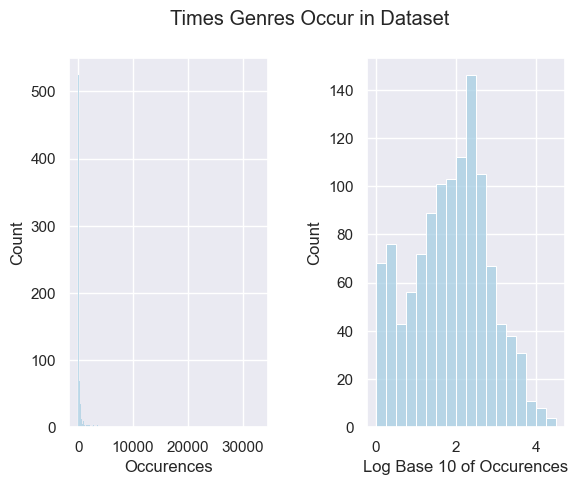

In [321]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

f1 = sns.histplot(genre_counts, ax = ax[0])
f2 = sns.histplot(np.log10(genre_counts), ax = ax[1])

f.suptitle('Times Genres Occur in Dataset')
f1.set(xlabel = 'Occurences')
_ =f2.set(xlabel = 'Log Base 10 of Occurences')

<h3>Remove Uncommon Classes</h3>

In [21]:
top_genres = df.top_genre.value_counts().sort_values(ascending = False)[:100]

In [326]:
df.top_genre.value_counts()[:100].sum() / df.shape[0]

0.9653210030232972

In [22]:
df['top_genre'] = df.top_genre.apply(lambda s: np.where(s in top_genres.index, s, 'Other'))

In [302]:
counts = df.top_genre.value_counts()[:25]

In [305]:
counts.loc['Other']

2730

/Users/haleyjohnson/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Top 25 Primary Genres'),
 Text(0.5, 0, 'Number of Occurences'),
 Text(0, 0.5, 'Genre')]

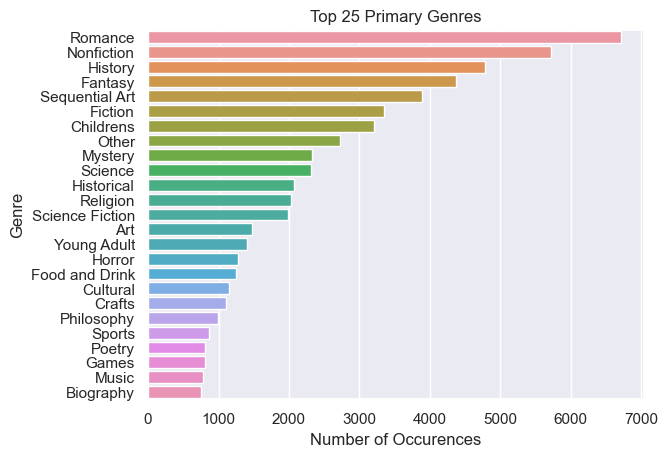

In [301]:
sns.set_palette("Paired")
f = sns.barplot(counts.values, counts.index)
_ = f.set(title = 'Top 25 Primary Genres', xlabel = 'Number of Occurences', ylabel = 'Genre') 

<h2>Test Train Split</h2>

In [120]:
# X = df.desc
X = df.drop(columns = ['top_genre'])
y = df.top_genre

X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state = 42, stratify = y) 

In [121]:
df_index = df.index
test_index = y_test.index
y_test_index = df_index.intersection(test_index)
y_test_df = df.loc[y_test_index]

train_index = y_train.index
y_train_index = df_index.intersection(train_index)
y_train_df = df.loc[y_train_index]

<h2>See Terms Associated with Each Genre</h2>
Inspred by code published <a href = "https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf#how-to-run-it-in-python-3">here</a>

In [123]:
tfidv = TfidfVectorizer(smooth_idf = True, lowercase = True, analyzer = 'word', stop_words = 'english', max_features = 10000)

X_train_tfidv = tfidv.fit_transform(X_train.desc)
X_test_tfidv = tfidv.transform(X_test.desc)

In [151]:
# this takes a long time to run! 

terms_array = X_train_tfidv.toarray()
genres_array = y_train.reset_index(drop = True)
dfs = {}

for i, desc in enumerate(terms_array):
    if i % 5000 == 0:
        print(i)
        
    desc_tfidf = list(zip(tfidv.get_feature_names_out(), desc))
    genre = genres_array[i]
    desc_df = pd.DataFrame.from_records(desc_tfidf, columns = ['word', 'score']).sort_values(by = 'score', ascending = False).reset_index(drop = True)

    if genre in list(dfs.keys()):
        dfs[genre].append(desc_df)
    else:
        dfs[genre] = []
        dfs[genre].append(desc_df)
    

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


In [152]:
# also takes a while to run!
genre_dfs = []
keys = list(dfs.keys())

for genre in keys: 
    vals = dfs[genre]
    genre_df = pd.concat(vals)
    genre_dfs.append(genre_df)


In [203]:
# takes a while to run

top_words_dfs = []
all_words_dfs = []
for i, temp_df in enumerate(genre_dfs):
    genre = keys[i]
    
    all_words = temp_df.groupby('word')['score'].mean().sort_values(ascending = False)
    top_words = all_words[:10]
    
    all_words_temp = pd.DataFrame(data = [all_words], index = [genre])
    top_words_temp =  pd.DataFrame(data = [top_words], index = [genre])
    
    all_words_dfs.append(all_words_temp)
    top_words_dfs.append(top_words_temp)


In [204]:
all_terms = pd.concat(all_words_dfs, axis = 0) 
all_terms = all_terms.fillna(value = 0)

top_terms = pd.concat(top_words_dfs, axis = 0)
top_terms = top_terms.fillna(value = 0)

In [205]:
top_terms.head()

word          church       god      book  christian  religion     jesus  \
Religion    0.039042  0.035968  0.035751   0.031387  0.026807  0.026071   
History     0.000000  0.000000  0.021372   0.000000  0.000000  0.000000   
Self Help   0.000000  0.000000  0.042930   0.000000  0.000000  0.000000   
Historical  0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   
Fiction     0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   

word           bible  testament      life  spiritual  ...  pirate  ship  \
Religion    0.023428   0.022469  0.021188   0.020392  ...     0.0   0.0   
History     0.000000   0.000000  0.000000   0.000000  ...     0.0   0.0   
Self Help   0.000000   0.000000  0.071366   0.000000  ...     0.0   0.0   
Historical  0.000000   0.000000  0.027485   0.000000  ...     0.0   0.0   
Fiction     0.000000   0.000000  0.032404   0.000000  ...     0.0   0.0   

word        survival  amy  dan  doc  climate  nature  sustainability  natural  
Religion         0.0  0.0  0.0  0.0      0.0     0.0             0.0      0.0  
History          0.0  0.0  0.0  0.0      0.0     0.0             0.0      0.0  
Self Help        0.0  0.0  0.0  0.0      0.0     0.0             0.0      0.0  
Historical       0.0  0.0  0.0  0.0      0.0     0.0             0.0      0.0  
Fiction          0.0  0.0  0.0  0.0      0.0     0.0             0.0      0.0  

[5 rows x 545 columns]

In [157]:
top_terms.to_csv("classes_top_terms.csv")

Code to fill dataframe with colors from <a href = "https://www.geeksforgeeks.org/set-pandas-dataframe-background-color-and-font-color-in-python/">this tutorial</a>

In [251]:
cm = sns.light_palette("blue", as_cmap = True)

top_terms.style.background_gradient(cmap = cm, axis = 1, low = 0, high = top_terms.max().max())

<h3>Find Most Similar Genres</h3>
Code adapted from <a href = "https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity">this StackOverflow post</a> 

In [289]:
similar_dict = {}
for genre in keys: 
    cosine_similarities = linear_kernel(np.array(all_terms.loc[genre]).reshape(1, -1), all_terms).flatten()
    similar_idx = cosine_similarities.argsort()[:-5:-1]
    similar_genres = [keys[idx] for idx in similar_idx if keys[idx] != genre]
    similar_dict[genre] = similar_genres


In [306]:
similar_dict['Computer Science']

['Design', 'Textbooks', 'Humanities']

In [311]:
similar_dict['Leadership']

['Business', 'Christian', 'Self Help']

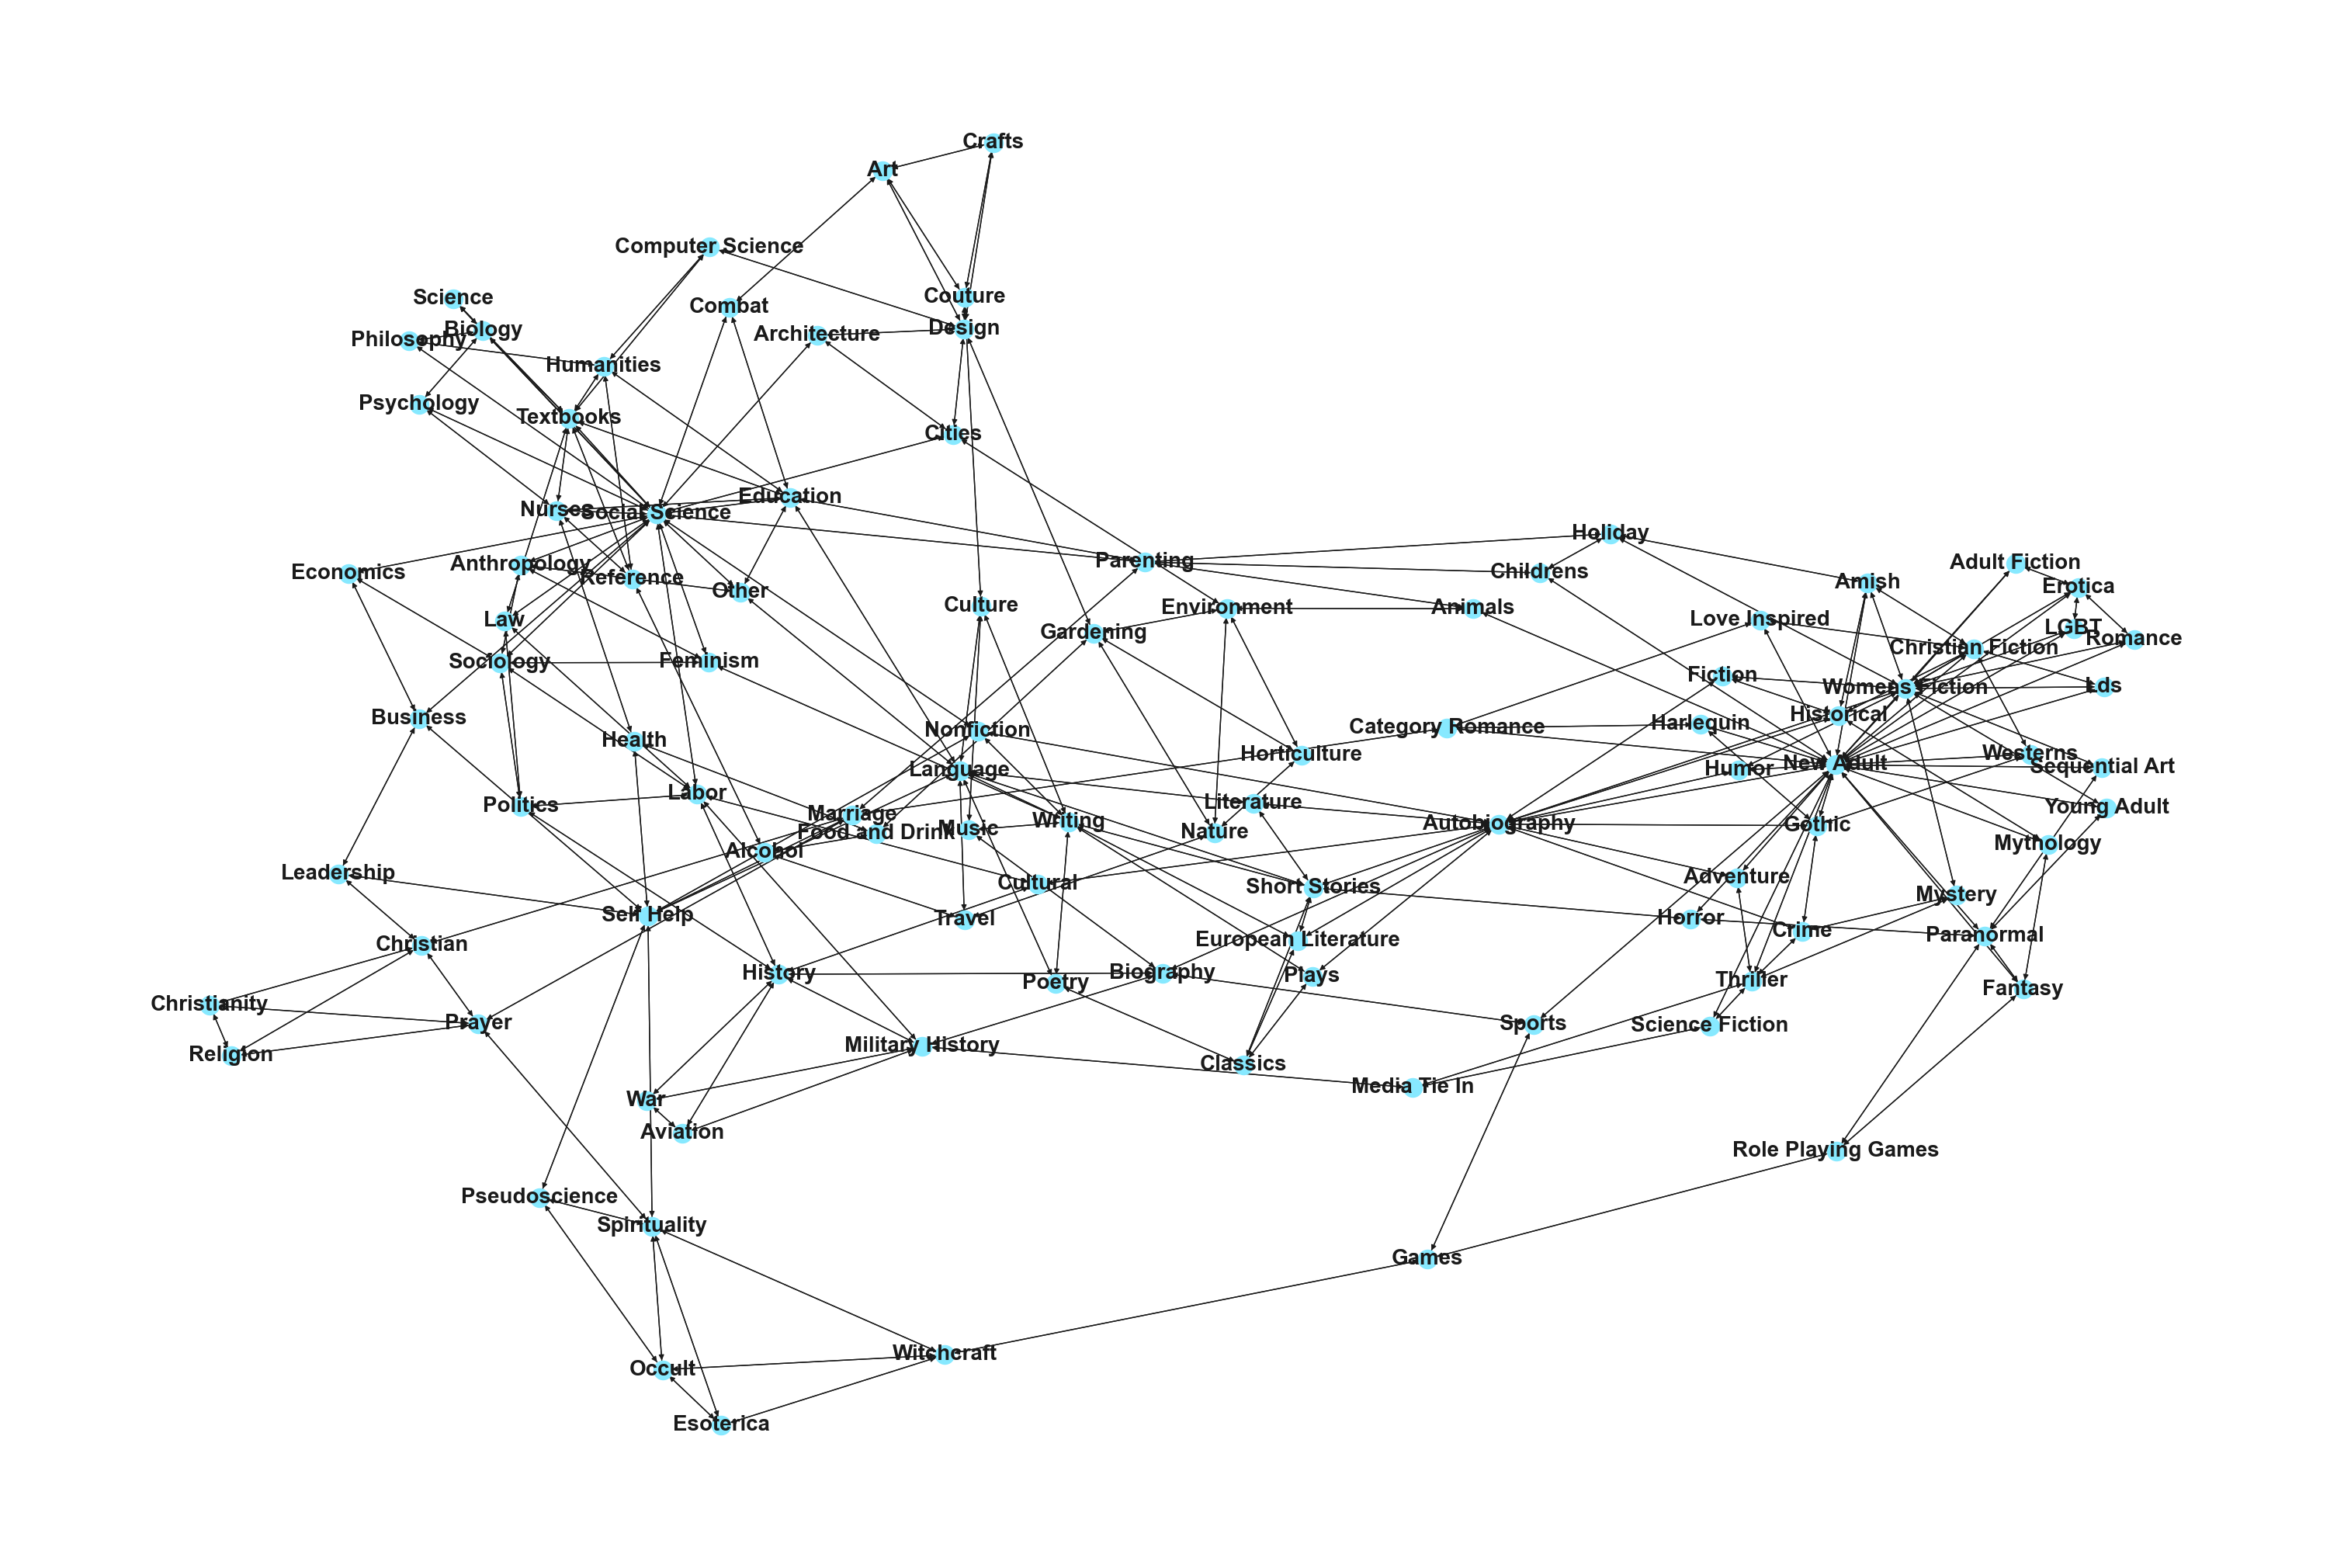

In [280]:
f = plt.figure(figsize=(30,20))
G = nx.Graph()
keys = list(similar_dict.keys())

for i in range(len(keys)):
    genre = keys[i]
    related_genres = similar_dict[keys[i]]
    G.add_node(genre)
    for related_genre in related_genres: 
        G.add_edges_from([(genre, related_genre)])

pos = nx.spring_layout(G)
G = G.to_directed()
nx.draw(G, with_labels = True, font_size=20, font_weight = 'bold', node_color = '#87e9ff')

<h2>Logstic Regression Baseline Model</h2>

In [ ]:
def genre_accuracy(s):
    pred_top_genre = 0
    pred_one_genre = 0

    pred = s.prediction
    all_genres = s.genres
    top_genre = s.genres[0]
    if pred == top_genre: 
        pred_top_genre = 1
    elif pred in all_genres:
        pred_one_genre = 1
    return (pred_top_genre, pred_one_genre)

In [ ]:
lr = LogisticRegression(max_iter = 200, random_state = 42, solver = 'sag')
lr = lr.fit(X_train_tfidv, y_train)

In [ ]:
y_pred = lr.predict(X_test_tfidv)
accuracy_score(y_test, y_pred)

In [ ]:
preds_df = test = pd.concat([pd.DataFrame(y_pred, columns = ['prediction']), X_test.reset_index(drop = True)], axis = 1)
accuracy_any_pos = preds_df.apply(genre_accuracy, axis = 1)

top_genre_accuracy = accuracy_any_pos.apply(lambda s: s[0])
any_position_accuracy = accuracy_any_pos.apply(lambda s: s[1])

In [ ]:
round(top_genre_accuracy.sum() / preds_df.shape[0], 2), round(any_position_accuracy.sum()/ preds_df.shape[0], 2)

<h2>Extra Trees Classifier</h2>

In [272]:
clf = ExtraTreesClassifier(random_state = 42)
params = {"n_estimators":[250, 400, 500], "max_depth":[64, None]}


extra_trees = GridSearchCV(clf, params, cv = 2, verbose = 3.1)
extra_trees.fit(X_train_tfidv, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ....max_depth=64, n_estimators=250;, score=0.412 total time= 2.6min
[CV 2/2] END ....max_depth=64, n_estimators=250;, score=0.409 total time= 2.1min
[CV 1/2] END ....max_depth=64, n_estimators=400;, score=0.414 total time= 3.3min


KeyboardInterrupt: 

In [ ]:
extra_trees.best_params_, extra_trees.best_score_

In [264]:
extra_trees.score(X_test_tfidv, y_test)

0.4640516233931203

In [228]:
y_pred = extra_trees.predict(X_test_tfidv)

In [252]:
preds_df = test = pd.concat([pd.DataFrame(y_pred, columns = ['prediction']), X_test.reset_index(drop = True)], axis = 1)
accuracy_any_pos = preds_df.apply(genre_accuracy, axis = 1)

top_genre_accuracy = accuracy_any_pos.apply(lambda s: s[0])
any_position_accuracy = accuracy_any_pos.apply(lambda s: s[1])

In [253]:
round(top_genre_accuracy.sum() / preds_df.shape[0], 2), round(any_position_accuracy.sum()/ preds_df.shape[0], 2)

(0.46, 0.29)

In [ ]:
features_importance = pd.DataFrame(data = {'features': tfidv.get_feature_names_out(), 'importance': extra_trees.feature_importances_})

In [ ]:
features_importance.sort_values(by = 'importance', ascending = False)[:100].values

<h2>Deep Learning Model</h2>

In [ ]:
MAX_LEN = 200
NUM_FEATURES = 10000
NUM_CLASSES = y_train.nunique()

In [ ]:
def pad_inputs(s, max_len = MAX_LEN):
    if len(s) < max_len:
        return [0] * (max_len - len(s)) + s
    elif len(s) > max_len:
        return s[:max_len]
    else:
        return s

In [ ]:
X_train = X_train.apply(pad_inputs)

In [ ]:
neural_net = Sequential([
    # layers.Embedding()
    layers.LSTM(128, batch_input_shape = (NUM_FEATURES, ), recurrent_dropout = 0.25, return_sequences = False), 
    layers.LSTM(32, recurrent_dropout = 0.25, return_sequences = True), 
    layers.Dropout(0.5), 
    layers.Dense(256, activation = 'relu'), 
    layers.Dense(NUM_CLASSES, activation = 'softmax')
])

opt = tf.keras.optimizers.Adam(learning_rate = 1e-5)
neural_net.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.0001, patience = 0)

In [ ]:
neural_net_history = neural_net.fit(X_train_bert, y_train, epochs = 20, callbacks = early_stopping)